In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arrowmatrix as amx
from arrowmatrix.util import resource_usage, si_units, timing

Net 107 MB, Total 107 MB


# Arrowmatrix Demo

Welcome to our speed demo!  In this notebook we will demonstrate the speed
of the new arrowmatrix formats, and compare against the speed and memory
usage for openmatrix using the ActivitySim framework.

To run this notebook, you need the MTC's large 'skims.omx' file. You'll also need
this same data transformed to two different file formats: parquet and feather.  The
following cell will do this for you, assuming you have a working internet connection.

In [2]:
if not os.path.exists('data/mtc_full_skims.omx'):
    import urllib.request
    url = 'https://github.com/RSGInc/activitysim_resources/raw/master/mtc_data_full/skims.omx'
    urllib.request.urlretrieve(url, 'data/mtc_full_skims.omx')
if not os.path.exists('data/mtc_full_skims.pmx'):
    amx.ParquetMatrix.from_hdf5('data/mtc_full_skims.omx', 'data/mtc_full_skims.pmx')
if not os.path.exists('data/mtc_full_skims.fmx'):
    amx.FeatherMatrix.from_arrow(
        amx.ParquetMatrix('data/mtc_full_skims.pmx'), 
        'data/mtc_full_skims.fmx',
        compression='uncompressed',
    )

In [3]:
from activitysim.abm.tables.skims import skim_dict
from activitysim.core import skim

In [4]:
settings = {
    'skims_file': 'mtc_full_skims.omx',
    'skim_time_periods': {
        'labels': ['EA', 'AM', 'MD', 'PM', 'EV']
    },
}

In [5]:
TEST_SIZE = 10_000_000
taz_values = np.arange(1,1476)
otaz = np.random.choice(taz_values, size=TEST_SIZE, replace=True)
dtaz = np.random.choice(taz_values, size=TEST_SIZE, replace=True)

# Open Matrix (ActivitySim)

In [6]:
with resource_usage:
    asim_skims = skim_dict(settings) # loads all skim data into memory

45.8 s: Net 7.11 GB, Total 7.45 GB


It takes some time to load, and a fair bit of RAM.  Now we can load values from one of the skim tables,
which is quick and easy, and only uses enough extra memory 
to store the values we have collected.

In [7]:
with resource_usage:
    asim_data1 = asim_skims.get('DISTBIKE').get(otaz,dtaz)

668 ms: Net 277 MB, Total 7.73 GB


# Parquet Matrix

Contrast that with the first of two formats of arrow matrix, ParquetMatrix.  
As we did above using the `skims_dict`, let's open the matrix reference itself first.

In [8]:
with resource_usage:
    pqmx = amx.ParquetMatrix('data/mtc_full_skims.pmx')

26.9 ms: Net 1e+03 KB, Total 7.73 GB


The matrix object can be created almost instantly because it
doesn't load all the data into RAM, just the schema and metadata.
The actual data remains on disk, waiting patiently for us to read
it later.  So let's do that!

In [9]:
with resource_usage:
    pqmx_data1 = pqmx.get_rc('DISTBIKE', otaz-1, dtaz-1, attach_index=False).to_numpy().reshape(-1).astype('float32')

264 ms: Net 39.8 MB, Total 7.77 GB


Loading this data from the arrow matrix requires barely more memory
footprint than the loaded data itself (the array of 10 million double-precision
floats uses 76.3 MB). We can double check that there's 
no cheating here: we actually loaded the correct data:

In [10]:
all(asim_data1 == pqmx_data1)

True

Well, you may say, that's nothing special.  The whole point of the 
ActivitySim skims module is to be fast, by having the necessary skims
preloaded into RAM so they can be read from as fast as possible.

In [11]:
%timeit asim_skims.get('DISTWALK').get(otaz,dtaz)

566 ms ± 23.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


`pqmx`: "Hold my beer"

In [12]:
%timeit pqmx.get_rc('DISTWALK', otaz-1, dtaz-1, attach_index=False).to_numpy().reshape(-1)

218 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Of course, there's no free lunch. Arrow is super fast, but 
reading data from disk has a high fixed cost. In particular, 
for Parquet (as configured in this demo, at least) we need
to read and decompress the entire source matrix data, to 
extract what we need. We can beat the 
pre-loaded ActivitySim skims when the chunk size is very large, 
but for very small chunk sizes the RAM solution is much faster. 

In [13]:
otaz2, dtaz2 = otaz[:50], dtaz[:50]

In [14]:
%timeit asim_skims.get('DISTWALK').get(otaz2,dtaz2)

9.47 µs ± 191 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [15]:
%timeit pqmx.get_rc('DISTWALK', otaz2-1, dtaz2-1, attach_index=False).to_numpy().reshape(-1)

19.6 ms ± 858 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


But what if I want the speed of in-memory data, but without actually needing to allocate all that memory?

# Feather Matrix

In [16]:
with resource_usage:
    fmx = amx.FeatherMatrix('data/mtc_full_skims_uncompressed.fmx')

1.08 s: Net 620 KB, Total 7.8 GB


Feather is able to point to space on disk and use it like RAM.  It's not quite as fast as
actual RAM, but these days solid state drives can get kind of close.  So, like ParquetMatrix above, 
we create the object reference almost instantly and with no overhead.

We can contrast now the performance with loading this big chunks...

In [17]:
%timeit fmx.get_rc('DISTBIKE', otaz-1, dtaz-1, attach_index=False).to_numpy().reshape(-1)

200 ms ± 7.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


... and the small chuncks.

In [18]:
%timeit fmx.get_rc('DISTWALK', otaz2-1, dtaz2-1, attach_index=False).to_numpy().reshape(-1)

140 µs ± 3.25 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Let's plot the relative speed across a variety of chunk sizes.

In [19]:
clock = dict(asim={}, parquet={}, feather={})

for j in np.logspace(1,np.log10(TEST_SIZE), 15).astype(int):
    otaz_ = otaz[:j]
    dtaz_ = dtaz[:j]
    clock['asim'][j] = np.mean(
        timing("asim_skims.get('DISTWALK').get(otaz_,dtaz_)", 
               globals=globals(), repeat=3, quiet=True)
    )
    clock['parquet'][j] = np.mean(
        timing("pqmx.get_rc('DISTWALK', otaz_-1, dtaz_-1, attach_index=False).to_numpy().reshape(-1)", 
               globals=globals(), repeat=3, quiet=True)
    )
    clock['feather'][j] = np.mean(
        timing("fmx.get_rc('DISTWALK', otaz_-1, dtaz_-1, attach_index=False).to_numpy().reshape(-1)", 
               globals=globals(), repeat=3, quiet=True)
    )


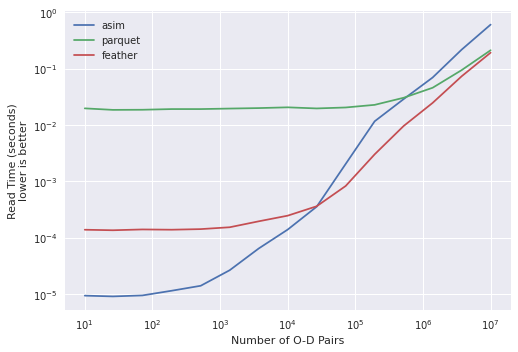

In [20]:
with plt.style.context('seaborn'):
    ax = pd.DataFrame(clock).plot(loglog=True)
    ax.set_xlabel("Number of O-D Pairs")
    ax.set_ylabel("Read Time (seconds)\nlower is better")